Importing the required modules

In [54]:
import warnings
warnings.filterwarnings('ignore')
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
from socceraction.xthreat import ExpectedThreat
from socceraction.vaep import VAEP
from socceraction import spadl
from socceraction.spadl.statsbomb import convert_to_actions
from socceraction.spadl import play_left_to_right

import xgboost
import pandas as pd
import numpy as np
import copy
import cv2

import pickle
from tqdm import tqdm
import warnings
import traceback
import json
import os, glob
from scipy.interpolate import interp1d
%matplotlib inline 
from matplotlib import pyplot as plt

Setting up the required variables

In [55]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

data = StatsBombLoader(getter="local", root="")    
games_with_three_sixty = [_id[:7] for _id in os.listdir("three-sixty")]

Loading all games with three-sixty

In [56]:
# get all files in matches directory recursively
all_matches = glob.glob('matches/**/*.json', recursive=True)

match_dict = {}
for matches in all_matches:
    with open(matches, "r", encoding="utf8") as file:
        matches_data = json.load(file)

    for match in matches_data:
        if(str(match['match_id']) in games_with_three_sixty):
            match_dict[str(match['match_id'])] = {}
            match_dict[str(match['match_id'])]['home_team_id'] = match['home_team']['home_team_id']
            match_dict[str(match['match_id'])]['season_id'] = match['season']['season_id']
            match_dict[str(match['match_id'])]['competition_id'] = match['competition']['competition_id']

Training the action value models

In [58]:
xt_model = ExpectedThreat(l=16, w=12)
VAEP_model = VAEP()

In [5]:
all_features, all_labels = [], []

files = os.listdir('three-sixty/')
for _file in tqdm(files):
    file_name = str(_file[:7])
    game_events = data.events(file_name, True)
    game = data.games(match_dict[file_name]['competition_id'], match_dict[file_name]['season_id'])
    game = game.loc[game['game_id'] == int(file_name)]
    _, game = next(game.iterrows())
    game_actions = spadl.statsbomb.convert_to_actions(game_events, match_dict[file_name])
    all_features.append(VAEP_model.compute_features(game, game_actions))
    all_labels.append(VAEP_model.compute_labels(game, game_actions))

all_features = pd.concat(all_features)
all_labels = pd.concat(all_labels)

VAEP_model.fit(all_features, all_labels)

  0%|          | 0/51 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [27]:
# pickle VAEP_model
with open('VAEP_model.pkl', 'wb') as f:
    pickle.dump(VAEP_model, f)


In [59]:
# load VAEP_model
with open('VAEP_model.pkl', 'rb') as f:
    VAEP_model = pickle.load(f)

Loading tracking content

In [7]:
def loadTrackingContent(path, tracking_content):
    with open(path, 'r') as file:
        raw_tracking = json.loads(file.read())

    for item in raw_tracking:
        tracking_content[item['event_uuid']] = item

def loadTrackingContentFromDir(dir, limit=-1):
    all_tracking_content = {}
    files = glob.glob(dir)
    for _file in (pbar := tqdm(files[:limit])):
        pbar.set_description(("File: " + _file))
        loadTrackingContent(_file, all_tracking_content)

    return all_tracking_content
        

In [8]:
def getWeightedFromArrays(x,y,z):
    nx = pitch_width 
    ny = pitch_height

    x=np.array(x)
    y=np.array(y)
    z=np.array(z)

    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    xi, yi = np.meshgrid(xi, yi)
    xi, yi = xi.flatten(), yi.flatten()

    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    zi = zi.reshape((ny, nx))

    zi = np.nan_to_num(zi)
    _max = np.min(zi)
    _min = np.max(zi)

    # get_space_bet_nums
    diff = _max - _min

    zi = (zi - _min) / diff
    return zi    

def drawSimple(frame):

    actor_frame = np.zeros(shape=(pitch_height,pitch_width), dtype=np.uint8)
    team_frame = np.zeros(shape=(pitch_height,pitch_width), dtype=np.uint8)
    opp_frame = np.zeros(shape=(pitch_height,pitch_width), dtype=np.uint8)

    actor_x, actor_y = -1, -1

    for player in frame['freeze_frame']:

        coords = opta_coords_to_spadl(player['location'][0], player['location'][1])
        if(player['actor']):
            actor_x = coords[0]
            actor_y = coords[1]

            # draw circle at actor_x, actor_y on actor_frame with cv2
            cv2.circle(actor_frame, coords, 3, (255,255,255), thickness=-1, lineType=cv2.LINE_AA, shift=0)
        elif(player['teammate']):
            # draw circle at x, y on team_frame with cv2
            cv2.circle(team_frame, coords, 3, (255,255,255), thickness=-1, lineType=cv2.LINE_AA, shift=0)
        elif(not player['teammate']):
            # draw circle at x, y on opp_frame with cv2
            cv2.circle(opp_frame, coords, 3, (255,255,255), thickness=-1, lineType=cv2.LINE_AA, shift=0)

    returning = np.array([actor_frame, team_frame, opp_frame, opp_frame], dtype=np.uint8).copy()
    returning = np.transpose(returning, (0,2,1))
    return returning

In [60]:
pitch_width, pitch_height = 105, 68

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1) * 2

def getXYZ(team_mates, opponents, frame):
    
    x , y, z = [], [], []
    
    nx = pitch_width
    ny = pitch_height

    x.append(0)
    x.append(nx)
    x.append(0)
    x.append(nx)

    y.append(0)
    y.append(0)
    y.append(ny)
    y.append(ny)

    z.append(0)
    z.append(0)
    z.append(0)
    z.append(0)

    actor_x, actor_y = -1, -1

    for player in frame['freeze_frame']:
        player['location'] = opta_coords_to_spadl(player['location'][0], player['location'][1])
        if(player['actor']):
            actor_x = int(player['location'][0])
            actor_y = int(player['location'][1])
            
            
        x_t = int(player['location'][0] )
        y_t = int(player['location'][1] )
        
        z_t = opponents if player['teammate'] else team_mates
        if player['actor']: z_t *= 0.3

        x.append(x_t)
        y.append(y_t)
        z.append(z_t)

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    return x, y, z, actor_x,  actor_y

def drawIDW(frame):

    x , y, z, actor_x, actor_y = getXYZ(1, -1, frame)
    zi = getWeightedFromArrays(x, y, z)

    just_actor_image = np.zeros(zi.shape)
    just_ball_image = np.zeros(zi.shape)
    cv2.circle(just_actor_image, (actor_x, actor_y), 3, (1), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    cv2.circle(just_ball_image, (actor_x, actor_y), 3, (1), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    
    # returning = np.array([just_actor_image*255, zi*255, inverted*255], dtype=np.uint8).copy()
    returning = np.array(zi*255, dtype=np.uint8)
    # returning = np.transpose(returning, (1,0))


    # mask the player
    # blank black image shape returning
    mask = np.zeros(returning.shape, dtype=np.uint8)
    # draw circle at actor_x, actor_y on mask with cv2
    cv2.circle(mask, (actor_x, actor_y), 30, (255), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    # mask the image with the circle
    returning = cv2.bitwise_and(returning, mask)

    # returning = np.transpose(returning, (1,0))

    return returning, mask

def drawIDWBlurred(frame):

    x , y, z, actor_x, actor_y = getXYZ(1, -1, frame)
    zi = getWeightedFromArrays(x, y, z)

    just_actor_image = np.zeros(zi.shape)
    just_ball_image = np.zeros(zi.shape)
    cv2.circle(just_actor_image, (actor_x, actor_y), 3, (1), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    cv2.circle(just_ball_image, (actor_x, actor_y), 3, (1), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    
    # returning = np.array([just_actor_image*255, zi*255, inverted*255], dtype=np.uint8).copy()
    returning = np.array(zi*255, dtype=np.uint8)
    # returning = np.transpose(returning, (1,0))

    # mask the player
    mask = np.zeros(returning.shape, dtype=np.uint8)
    # draw circle at actor_x, actor_y on mask with cv2
    cv2.circle(mask, (actor_x, actor_y), 30, (255), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    # mask the image with the circle
    returning = cv2.bitwise_and(returning, mask)

    # returning = np.transpose(returning, (1,0))
    return returning, mask

In [63]:
def just_coords(frame):
    actor = [[-10.0,-10.0]]
    team_mates = np.array([(-10,-10) for i in range(10)], dtype=np.float16)
    opponents = np.array([(-10,-10) for i in range(11)], dtype=np.float16)

    team_c, opp_c = 0, 0

    for player in frame['freeze_frame']:
        p_l = normalise_coords(player['location'][0], player['location'][1])

        team_c = min(9, team_c)
        opp_c = min(10, opp_c)
        if(player['actor']):
            actor[0][0] = p_l[0]
            actor[0][1] = p_l[1]
        elif player['teammate']:
            team_mates[team_c][0] = p_l[0]
            team_mates[team_c][1] = p_l[1]
            team_c += 1
        if not player['teammate']:
            opponents[opp_c][0] = p_l[0]
            opponents[opp_c][1] = p_l[1]
            opp_c += 1

    final = np.concatenate([actor,team_mates,opponents], dtype = np.float16)   
    return final

In [11]:
def opta_coords_to_spadl(x, y):
    return (int((x*105/120)), int((y*68/80)))

def normalise_coords(x, y):
    return ((x/120)*2 - 1, (y/80)*2 - 1)

Get the VAEP for all the actions within each game

In [12]:
def get_action_vector(action):
    return [1 if action['type_name'] == a  else 0 for a in good_actions]

In [13]:
def alphaBlend(img1, img2, mask):
    """ alphaBlend img1 and img 2 (of CV_8UC3) with mask (CV_8UC1 or CV_8UC3)
    """
    if mask.ndim==3 and mask.shape[-1] == 3:
        alpha = mask/255.0
    else:
        alpha = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)/255.0
    blended = cv2.convertScaleAbs(img1*(1-alpha) + img2*alpha)
    return blended

In [50]:
files = os.listdir('three-sixty/')
limit = -1

tracking_content = loadTrackingContentFromDir('three-sixty/*.json', limit=limit)
good_actions = ['pass', 'shot', 'dribble', 'clearance']

x = []
y = []
rewards = []
event_ids = []
terminals = []
real_positions = []
file_names = []
idws = []
orig_coords = []

event_uuid_to_player = {}

failcount = 0
successcount = 0
break_flag = False
for _file in tqdm(tqdm_files := tqdm(files[:limit])):
    file_name = _file[:7]

    game_events = data.events(file_name, True)
    tqdm_files.set_description(("File: " + _file + " ... " + f"{failcount}/{failcount+successcount}" ))
    ac = spadl.add_names(convert_to_actions(game_events, match_dict[file_name]))
    ac = play_left_to_right(ac, match_dict[file_name])

    game = data.games(match_dict[file_name]['competition_id'], match_dict[file_name]['season_id']).set_index("game_id")
    game = game.loc[int(file_name)]

    players_in_game = data.players(file_name)
    actions_rated = VAEP_model.rate(game, ac)

    for rated_action in range(len(ac))[0:]:
        # get the action type to see whether or not to discard
        action = ac.iloc[rated_action]
        if(action['type_name'] not in good_actions):
            continue

        # get the player from players_in_game where the player_id matches the action's player_id
        player_name = players_in_game.loc[players_in_game['player_id'] == action['player_id']]['player_name'].array[0]

        event_uuid_to_player[action['original_event_id']] = [action['player_id'], player_name]
           
        # get the event id to get the tracking data and draw the image
        # try:
        try:
            related_event = tracking_content[str(action['original_event_id'])]
            successcount  += 1
        except KeyError as e:
            failcount += 1
            continue

        
        a, mask = drawIDW(copy.deepcopy(related_event))
        
        # x_s = drawSimple(related_event)
        # a = np.transpose(a, (1,0))

        # x_s[3] = a

        # # concatenate
        # x.append(x_s)

        # get the action vector
        v1 = get_action_vector(action)
        v1.append(2*(action['end_x']/105)- 1)
        v1.append(2*((68-action['end_y'])/68) - 1)

        orig_coords.append(related_event)

        y.append(v1)
        rewards.append(actions_rated.iloc[rated_action]['vaep_value'])
        terminals.append(1-action['result_id'])
        event_ids.append(action['original_event_id'])

        real_positions.append((action['end_x'], 68-action['end_y']))
        file_names.append(file_name)
    

100%|██████████| 50/50 [15:12<00:00, 18.25s/it]


In [41]:
event_uuid_to_player


{'bbc398f7-c784-4958-a504-37b583caf97a': [11086.0, 'Burak Yılmaz'],
 '605315c0-8960-4f53-94cb-87ae77e86750': [8963.0, 'Caglar Söyüncü'],
 '5c210f79-9714-44a6-b2ec-387f6a117b37': [8963.0, 'Caglar Söyüncü'],
 '37105d1f-4313-4db6-b8ba-76c224e488ca': [8541.0, 'Kenan Karaman'],
 '27fdb7ff-f108-4d83-84bf-7d2dace7c40f': [6954.0, 'Giorgio Chiellini'],
 'f8e61bb0-b618-4695-9ff9-eaa0584bdbfa': [6954.0, 'Giorgio Chiellini'],
 '38dc9935-ad24-456f-9a78-b40233519f7f': [7036.0, 'Gianluigi Donnarumma'],
 '1d72ce76-31fd-43e0-a6b2-1f78c8a57a77': [7036.0, 'Gianluigi Donnarumma'],
 '846af57b-721e-4802-8af5-6c55fb23d969': [7173.0, 'Leonardo Bonucci'],
 '5ddc5023-88c9-4971-b694-b51cc9f33b18': [7173.0, 'Leonardo Bonucci'],
 '3150a747-b5e2-4805-9aac-122ce6e6b684': [6954.0, 'Giorgio Chiellini'],
 'f1760b14-9c4f-4c0e-91f3-53b71b0f9ce2': [6954.0, 'Giorgio Chiellini'],
 '95fe72d2-6c2e-44d3-96c2-baa8a5a1bd57': [7173.0, 'Leonardo Bonucci'],
 '6ef03094-6049-4a4a-b373-b61b93c3aa3f': [7173.0, 'Leonardo Bonucci'],
 'e1

Save the dataset to disk

In [123]:
actions = np.array([[int(pitch_width*(a[4]+1)/2), int(pitch_height*(a[5]+1)/2)] for a in y1])

NameError: name 'y1' is not defined

In [188]:
loaded_file = np.load("saved_datasets/idw_dataset.npz")
x1, y1, r1, event_ids1, t1, _, _ = loaded_file['arr_0'], loaded_file['arr_1'], loaded_file['arr_2'], loaded_file['arr_3'], loaded_file['arr_4'], loaded_file['arr_5'], loaded_file['arr_6']

In [1]:
x1[0][1].shape

NameError: name 'x1' is not defined

In [16]:
v_at_p = np.array([x1[i][1][min(a[0], pitch_width-1)][min(a[1], pitch_height-1)] for i, a in enumerate(actions)])

NameError: name 'actions' is not defined

In [16]:
print("lol")
import torch

lol


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
# draw histogram of v_at_p
plt.hist(v_at_p, bins=100)
plt.show()

NameError: name 'plt' is not defined

In [52]:
np.savez("saved_datasets\\simple_x_idw_without_obs.npz",
            # np.array(x, dtype=np.uint8),
            np.array(y),
            np.array(rewards),
            np.array(event_ids),
            np.array(terminals), 
            np.array(v_at_p),
            np.array(orig_coords),
            np.array(event_uuid_to_player)
        )

(68, 105) (68, 105) (68, 105)
alpha (68, 105)


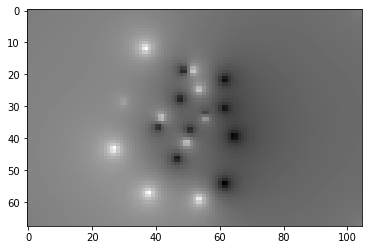

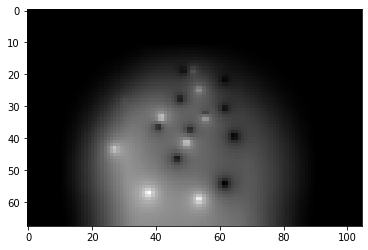

In [171]:
def voronoi():
    team_x = []
    team_y = []

    opp_x = []
    opp_y = []

    team_ = []

    total_x = []
    total_y = []

    for item in tracking_data['freeze_frame']:
        if item['teammate']:
            team_x.append(item['location'][0])
            team_y.append(item['location'][1])
            team_.append(0)
        else:
            opp_x.append(item['location'][0])
            opp_y.append(item['location'][1])
            team_.append(1)
            
        total_x.append(item['location'][0])
        total_y.append(item['location'][1])


def drawIDWBlurred(frame):

    x , y, z, actor_x, actor_y = getXYZ(1, -1, frame)
    zi = getWeightedFromArrays(x, y, z)

    just_actor_image = np.zeros(zi.shape)
    just_ball_image = np.zeros(zi.shape)
    cv2.circle(just_actor_image, (actor_x, actor_y), 3, (1), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    cv2.circle(just_ball_image, (actor_x, actor_y), 3, (1), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    
    # returning = np.array([just_actor_image*255, zi*255, inverted*255], dtype=np.uint8).copy()
    returning = np.array(zi*255, dtype=np.uint8)

    # mask the player
    mask = np.zeros(returning.shape, dtype=np.uint8)
    cv2.circle(mask, (actor_x, actor_y), 35, (255), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    
    # returning = cv2.bitwise_and(returning, mask)
    return returning, mask


def normalize_2d(matrix):
		mn = np.min(matrix)
		mx = np.max(matrix)

		m2 = np.zeros(matrix.shape)
		for i in range (m2.shape[0]):
			for j in range (m2.shape[1]):
				m2[i][j] = (matrix[i][j]-mn)/(mx-mn)

		return m2

def alphaBlend(img1, img2, mask):
    """ alphaBlend img1 and img 2 (of CV_8UC3) with mask (CV_8UC1 or CV_8UC3)
    """

    print(img1.shape, img2.shape, mask.shape)
    alpha = mask/255


    print("alpha", alpha.shape)
    blended = cv2.convertScaleAbs(img1*(1-alpha) + img2*alpha)
    return blended


def drawBlackFromX(center, idws):
    black = np.zeros((pitch_height, pitch_width))

    img = np.zeros((pitch_height, pitch_width))
    cv2.circle(img, center, 30, (255,255,255), -1, cv2.LINE_AA)
    mask = cv2.GaussianBlur(img, (21,21),11 )

    return alphaBlend(black, idws, mask)



a, b = drawIDWBlurred(
    copy.deepcopy(orig_coords[1])
)

img = drawBlackFromX((50,50), a)

plt.imshow(a, cmap='gray', vmin=0, vmax=255)
plt.show()

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [161]:
aatt = 6566

print("Reward is: ", v_at_p[aatt], "at", actions[aatt])
x2 = np.transpose(x1,(0,1, 3,2))
cv2.imshow("test", x2[aatt][1])
cv2.waitKey(0)
cv2.destroyAllWindows()


Reward is:  130 at [81  5]


In [164]:
# round to the nearest integer

pos_only[0]

array([28, 24], dtype=uint8)

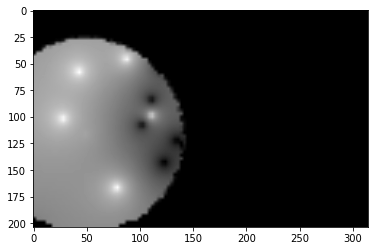

rendered image: 



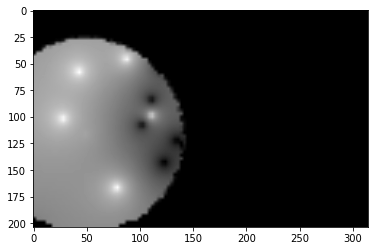

In [42]:
import copy

n = 8

coords = copy.deepcopy(orig_coords[n])

test_i,_= drawIDW(coords)

plt.imshow(cv2.resize(np.transpose(x[n][3], (1,0)), (0,0), fx=3, fy=3), cmap="gray")
plt.show()

print("rendered image: ")
print()
plt.imshow(cv2.resize(np.transpose(test_i, (0,1)), (0,0), fx=3, fy=3), cmap='gray')
plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()


In [129]:
np.savez("saved_datasets\\t2.npz", np.array(x, dtype=np.uint8), np.array(y), np.array(rewards), np.array(event_ids), np.array(terminals), np.array(idws), np.array(file_names))

Sample action output

In [44]:
pos_only = np.array([[np.round(pitch_width*(1+a[4])/2), np.round(pitch_height*(a[5]+1)/2)] for a in y], dtype=np.uint8)

# n = 1000
v_at_p = []

for n in range (len(y)):
    # p = (58, 8)
    p = (min(pos_only[n][0], pitch_width-1), min(pos_only[n][1], pitch_height-1))
    # print(p)
    bf = copy.deepcopy(x[n][3])
    # print(bf.shape)
    bf = np.transpose(bf, (1,0))
    # print("Value", bf[p[0]][p[1]], bf.shape)
    # print("-------------")
    v_at_p.append(bf[p[1]][p[0]])
    # print(bf.shape)
    # print("at", p)

    # # draw circle on f at p
    # cv2.circle(bf, p, 5, (0,0,255), -1)
    # bf = cv2.resize(bf, (0,0), fx=4, fy=4)

    # cv2.imshow("ttesting", bf)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

v_at_p = (np.array(v_at_p)/255)-0.5

In [161]:
cv2.imshow("test", x[0])
cv2.waitKey(0)
cv2.destroyAllWindows()


In [18]:
# import matplotlib.pyplot as plt
# draw hisogram of v_at_p
plt.hist(v_at_p, bins=10)
plt.show()

# draw boxplot of v_at_p using plt
plt.boxplot(v_at_p)
plt.show()

NameError: name 'plt' is not defined

In [19]:
v_at_p.min(), v_at_p.max(), v_at_p.mean()

NameError: name 'v_at_p' is not defined